# Exercise
You can use code and models which are publicly available. Please provide: short description what
you did, how it is done, what is the result. Please be prepared to present the solution in the exercises
(best in form of a Jupyter notebook .ipynb).

(a) (6 Pts.) 

Take a model for the FashionMNIST or MNIST data set. Take 2 different examples
from two different classes. Use at least three local explanation methods (you implemented
yourself) and explain reasons they are mapped to the true, the most likely, second most likely,
and least likely class. Interpret the results. Are the explanations meaningful? Do they differ for
different target outputs? What happens if the examples are adversarially attacked (with a local
change of only small parts of the image)? Also try this out experimentally.

In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
from skimage.color import rgb2gray

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random

In [7]:
# Transformations for the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

In [8]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = x.view(-1, 64 * 5 * 5)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return nn.LogSoftmax(dim=1)(x)

# Instantiate and train the model
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
for epoch in range(1, 6):  # 5 epochs
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluate the model
model.eval()
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

print(f'Accuracy: {correct / len(test_loader.dataset):.4f}')

Epoch 1, Loss: 0.23787033557891846
Epoch 2, Loss: 0.2737005054950714
Epoch 3, Loss: 0.15937817096710205
Epoch 4, Loss: 0.09012910723686218
Epoch 5, Loss: 0.2267945408821106
Accuracy: 0.9002


In [9]:
# Function to collect examples
def collect_examples(test_loader, num_classes=2, examples_per_class=2):
    examples = []
    for data, target in test_loader:
        for i in range(len(data)):
            if len(examples) == num_classes * examples_per_class:
                break
            if target[i].item() in range(num_classes) and len([x for x in examples if x[1] == target[i].item()]) < examples_per_class:
                examples.append((data[i], target[i].item()))
        if len(examples) == num_classes * examples_per_class:
            break
    return examples

### Saliency Maps

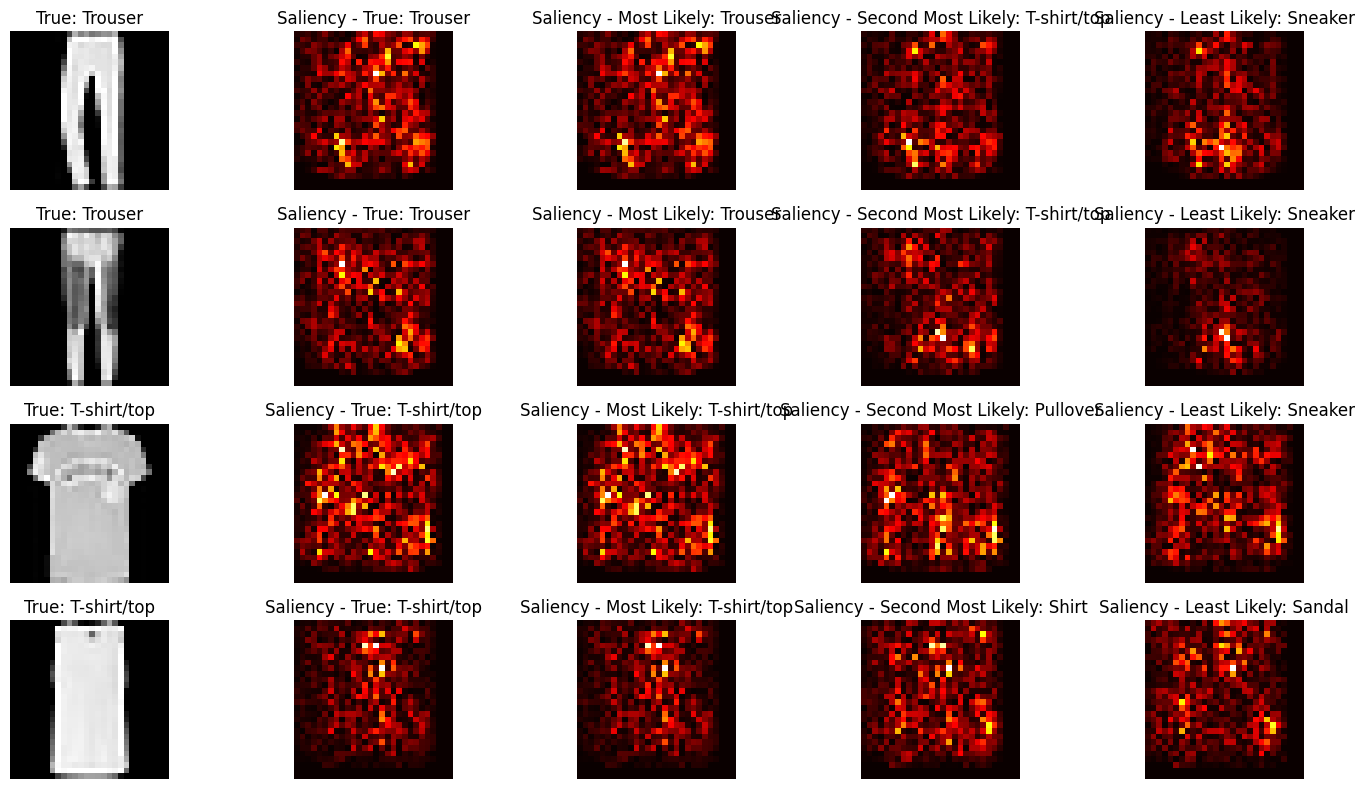

In [10]:
# Function to compute saliency maps for a specific class
def compute_saliency_maps(X, model, class_idx):
    model.eval()
    X.requires_grad_()
    scores = model(X)
    class_score = scores[:, class_idx]
    model.zero_grad()
    class_score.backward(torch.ones_like(class_score))
    saliency, _ = torch.max(X.grad.data.abs(), dim=1)
    return saliency



# Function to show saliency maps
def show_saliency_maps(model, test_loader, class_names):
    examples = collect_examples(test_loader)
    fig, axes = plt.subplots(len(examples), 5, figsize=(15, 8))
    for i, (img, label) in enumerate(examples):
        img = img.unsqueeze(0)
        output = model(img)
        preds = output.argsort(dim=1, descending=True)
        axes[i, 0].imshow(img.squeeze().detach().numpy(), cmap='gray')
        axes[i, 0].set_title(f"True: {class_names[label]}")
        axes[i, 0].axis('off')

        class_indices = [label, preds[0, 0].item(), preds[0, 1].item(), preds[0, -1].item()]
        titles = [f"True: {class_names[label]}", 
                  f"Most Likely: {class_names[preds[0, 0].item()]}", 
                  f"Second Most Likely: {class_names[preds[0, 1].item()]}", 
                  f"Least Likely: {class_names[preds[0, -1].item()]}"]

        for j, class_idx in enumerate(class_indices):
            saliency_map = compute_saliency_maps(img, model, class_idx)
            axes[i, j+1].imshow(saliency_map.squeeze().detach().numpy(), cmap='hot')
            axes[i, j+1].set_title(f"Saliency - {titles[j]}")
            axes[i, j+1].axis('off')
    
    plt.tight_layout()
    plt.show()

show_saliency_maps(model, test_loader, class_names)

### Integrated Gradients

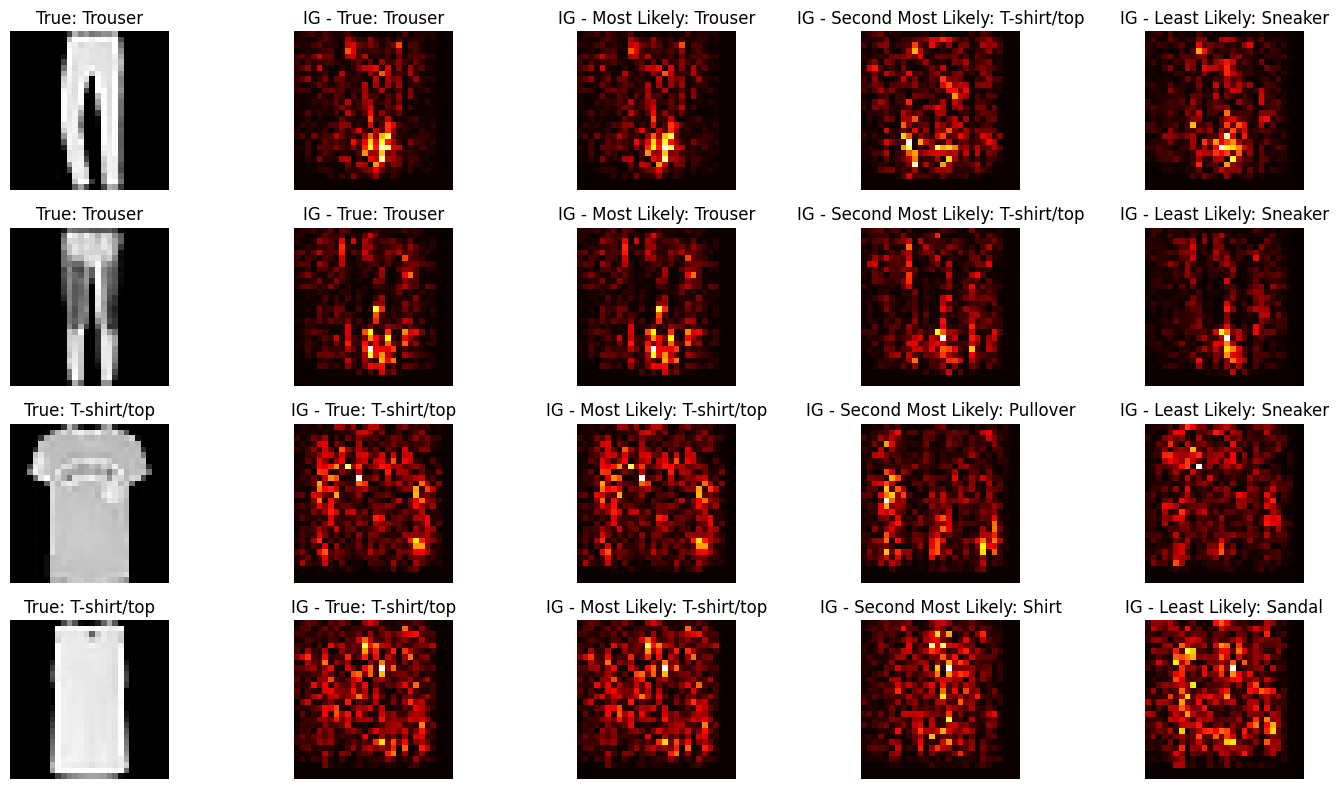

In [11]:
# Function to compute integrated gradients
def integrated_gradients(X, model, class_idx, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(X)
    assert baseline.shape == X.shape

    model.eval()
    X.requires_grad_()
    baseline.requires_grad_()
    
    # Compute scaled inputs
    scaled_inputs = [baseline + (float(i) / steps) * (X - baseline) for i in range(0, steps + 1)]
    scaled_inputs = torch.cat(scaled_inputs, dim=0)

    # Compute gradients for each scaled input
    scaled_inputs.requires_grad_()
    scores = model(scaled_inputs)
    class_score = scores[:, class_idx]
    grads = torch.autograd.grad(class_score.sum(), scaled_inputs)[0]
    
    # Compute the average of the gradients and multiply by the difference between the input and the baseline
    avg_grads = torch.mean(grads.view((steps + 1, *X.shape)), dim=0)
    integrated_grad = (X - baseline) * avg_grads
    integrated_grad, _ = torch.max(integrated_grad.abs(), dim=1)
    return integrated_grad

# Function to show integrated gradients
def show_integrated_gradients(model, test_loader, class_names):
    examples = collect_examples(test_loader)
    fig, axes = plt.subplots(len(examples), 5, figsize=(15, 8))
    for i, (img, label) in enumerate(examples):
        img = img.unsqueeze(0)
        output = model(img)
        preds = output.argsort(dim=1, descending=True)
        axes[i, 0].imshow(img.squeeze().detach().numpy(), cmap='gray')
        axes[i, 0].set_title(f"True: {class_names[label]}")
        axes[i, 0].axis('off')

        class_indices = [label, preds[0, 0].item(), preds[0, 1].item(), preds[0, -1].item()]
        titles = [f"True: {class_names[label]}", 
                  f"Most Likely: {class_names[preds[0, 0].item()]}", 
                  f"Second Most Likely: {class_names[preds[0, 1].item()]}", 
                  f"Least Likely: {class_names[preds[0, -1].item()]}"]

        for j, class_idx in enumerate(class_indices):
            integrated_grad = integrated_gradients(img, model, class_idx)
            axes[i, j+1].imshow(integrated_grad.squeeze().detach().numpy(), cmap='hot')
            axes[i, j+1].set_title(f"IG - {titles[j]}")
            axes[i, j+1].axis('off')
    
    plt.tight_layout()
    plt.show()

show_integrated_gradients(model, test_loader, class_names)

### LIME

In [23]:
# Function to collect examples
def collect_examples_rgb(test_loader, num_classes=2, examples_per_class=2):
    examples = []
    for data, target in test_loader:
        for i in range(len(data)):
            if len(examples) == num_classes * examples_per_class:
                break
            if target[i].item() in range(num_classes) and len([x for x in examples if x[1] == target[i].item()]) < examples_per_class:
                # Convert grayscale to RGB
                if data[i].shape[1] == 1:  # Check if the image is grayscale
                    # Convert grayscale to RGB by repeating the single channel across 3 channels
                    data_rgb = data[i].expand(-1, 3, -1, -1)
                    # Alternatively, you can concatenate along the channel dimension
                    # data_rgb = torch.cat([data[i]] * 3, dim=1)
                else:
                    data_rgb = data[i]  # Already RGB
                
                examples.append((data_rgb, target[i].item()))
                
        if len(examples) == num_classes * examples_per_class:
            break
            
    return examples

torch.Size([1, 1, 28, 28])


ValueError: the input array must have size 3 along `channel_axis`, got (28, 28)

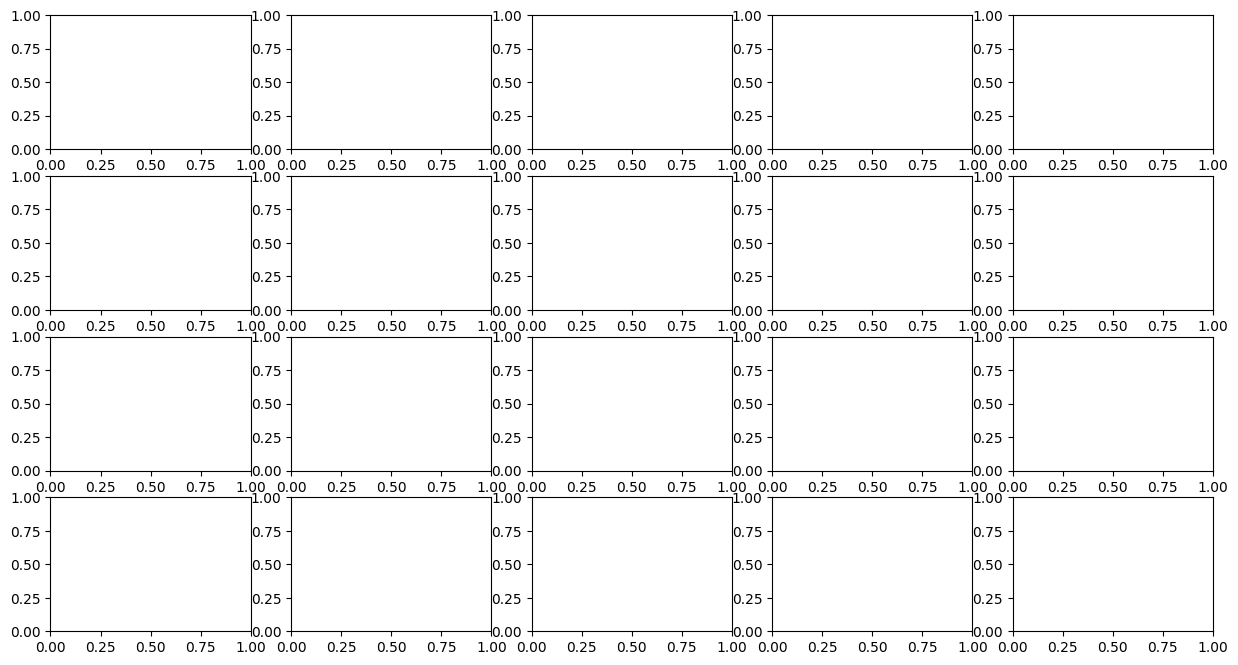

In [24]:
# Function to show LIME explanations
def show_lime_explanations(model, test_loader, class_names):
    examples = collect_examples_rgb(test_loader)
    print(examples[0][0].unsqueeze(1).shape)
    fig, axes = plt.subplots(len(examples), 5, figsize=(15, 8))
    explainer = LimeImageExplainer()

    def batch_predict(images):
        model.eval()    
        batch = torch.stack(tuple(transform(rgb2gray(image)) for image in images), dim=0)  # Convert RGB to grayscale
        batch = batch.to(next(model.parameters()).device)
        logits = model(batch)
        probs = F.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()

    for i, (img, label) in enumerate(examples):
        img = img.unsqueeze(0)
        output = model(img)
        preds = output.argsort(dim=1, descending=True)
        img_np = img.squeeze().detach().numpy()

        explanation = explainer.explain_instance(
            image=rgb2gray(img_np),  # Convert RGB to grayscale
            classifier_fn=batch_predict,
            top_labels=10,
            hide_color=0,
            num_samples=1000
        )

        axes[i, 0].imshow(img_np, cmap='gray')
        axes[i, 0].set_title(f"True: {class_names[label]}")
        axes[i, 0].axis('off')

        class_indices = [label, preds[0, 0].item(), preds[0, 1].item(), preds[0, -1].item()]
        titles = [f"True: {class_names[label]}", 
                  f"Most Likely: {class_names[preds[0, 0].item()]}", 
                  f"Second Most Likely: {class_names[preds[0, 1].item()]}", 
                  f"Least Likely: {class_names[preds[0, -1].item()]}"]

        for j, class_idx in enumerate(class_indices):
            temp, mask = explanation.get_image_and_mask(
                label=class_idx,
                positive_only=True,
                num_features=10,
                hide_rest=False
            )
            axes[i, j+1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
            axes[i, j+1].set_title(f"LIME - {titles[j]}")
            axes[i, j+1].axis('off')

    plt.tight_layout()
    plt.show()

show_lime_explanations(model, test_loader, class_names)